In [230]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

### Load modules

In [231]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Running on PyMC3 v3.11.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Import Data from Sheets or BigQuery

## From Sheets

In [232]:
#@title Parameters

#INPUT_SHEET_NAME = 'uncleaned data' #@param {type:"string"}

In [233]:
'''
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')
'''

"\nworksheet = gc.open(INPUT_SHEET_NAME).sheet1\n\n# get_all_values gives a list of rows.\nrows = worksheet.get_all_values()\n\ndf=pd.DataFrame.from_records(rows)\n\n\n#get column names from first row\ndf.columns = df.iloc[0]\n\n#drop row with column names\ndf = df.drop(df.index[0])\n\n#reset indexes\ndf = df.reset_index(drop=True)\n\n#convert numeric data to numeric types\ndf = df.apply(pd.to_numeric, errors='ignore')\n"

## From BigQuery

In [234]:
%%bigquery df
SELECT *
FROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`
WHERE Division IS NOT NULL;

In [235]:
df.head()

,Division,day,total_clicks,NonBrand_clicks,Brand_clicks,Brand_x_RMKT_x_EC_clicks,Brand_x_Core_x_NC_clicks,NonBrand_x_Core_x_NC_clicks,Brand_x_RMKT_x_NCFM_clicks,NonBrand_x_RMKT_x_NCFM_clicks,BingYahoo_clicks,Google_clicks,Google_div_BingYahoo_ratio,core_clicks,rmkt_clicks,top_clicks,LOB_other_clicks,LOB_top_div_other_ratio,keyword_comcast_clicks,keyword_xfinity_clicks,keyword_other_clicks,exact_clicks,match_type_other_clicks,search_mobile_clicks,search_desktop_clicks,search_mobile_div_desktop_ratio,search_NC_clicks,search_EC_clicks,search_other_audience_clicks,core_x_xfinity_clicks,core_x_comcast_clicks,core_x_other_keyword_clicks,rmkt_x_xfinity_clicks,rmkt_x_comcast_clicks,rmkt_x_other_keyword_clicks,core_x_NC_clicks,core_x_EC_clicks,core_x_Audience_Other_clicks,rmkt_x_NC_clicks,rmkt_x_EC_clicks,rmkt_x_Audience_Other_clicks,NC_x_xfinity_clicks,EC_x_xfinity_clicks,Audience_Other_x_xfinity_clicks,NC_x_comcast_clicks,EC_x_comcast_clicks,Audience_Other_x_comcast_clicks,NC_x_keyword_other,EC_x_keyword_other,Audience_Other_x_keyword_other,tactic_Core_x_keyword_xfinity_x_audience_NC,tactic_Core_x_keyword_xfinity_x_audience_EC,tactic_Core_x_keyword_xfinity_x_audience_other,tactic_Core_x_keyword_comcast_x_audience_NC,tactic_Core_x_keyword_comcast_x_audience_EC,tactic_Core_x_keyword_comcast_x_audience_other,tactic_Core_x_keyword_other_x_audience_NC,tactic_Core_x_keyword_other_x_audience_EC,tactic_Core_x_keyword_other_x_audience_other,tactic_RMKT_x_keyword_xfinity_x_audience_NC,tactic_RMKT_x_keyword_xfinity_x_audience_EC,tactic_RMKT_x_keyword_xfinity_x_audience_other,tactic_RMKT_x_keyword_comcast_x_audience_NC,tactic_RMKT_x_keyword_comcast_x_audience_EC,tactic_RMKT_x_keyword_comcast_x_audience_other,tactic_RMKT_x_keyword_other_x_audience_NC,tactic_RMKT_x_keyword_other_x_audience_EC,tactic_RMKT_x_keyword_other_x_audience_other,Division_x,total_imps,AOL_div_Amazon_imps_ratio,Oath_div_Rocketfuel_imps_ratio,Oath_div_Amazon_imps_ratio,Oath_div_DBM_imps_ratio,Oath_div_TTD_imps_ratio,Oath_div_OTHER_imps_ratio,DBM_imps,Rocketfuel_imps,Amazon_imps,Oath_imps,OTHER_imps,Pandora_imps,TTD_imps,Display_imps,Audio_imps,Video_imps,Social_imps,Desktop_imps,Mobile_imps,desktop_div_mobile_imps,ACQ_imps,AWA_imps,RTG_imps,Display_x_ACQ_imps,Display_x_AWA_imps,Display_x_RTG_imps,Audio_x_ACQ_imps,Audio_x_AWA_imps,Audio_x_RTG_imps,Social_x_ACQ_imps,Social_x_AWA_imps,Social_x_RTG_imps,Video_x_ACQ_imps,Video_x_AWA_imps,Video_x_RTG_imps,Desktop_x_ACQ_imps,Desktop_x_AWA_imps,Desktop_x_RTG_imps,Mobile_x_ACQ_imps,Mobile_x_AWA_imps,Mobile_x_RTG_imps,OTHER_x_Video_x_AWA_imps,Oath_x_Display_x_AWA_imps,Oath_x_Video_x_AWA_imps,Oath_x_Audio_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,Oath_x_Audio_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,OTHER_x_Display_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,OTHER_x_Audio_x_AWA_imps,OTHER2_x_Audio_x_AWA_imps,OTHER_x_Audio_x_ACQ_imps,Pandora_x_Audio_x_ACQ_imps,The_Trade_Desk_x_Video_x_ACQ_imps,Rocketfuel_x_Video_x_ACQ_imps,Amazon_x_Display_x_ACQ_imps,DBM_x_Audio_x_AWA_imps,OTHER_x_Social_x_ACQ_imps,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,OTHER_x_Display_x_RTG_imps,OTHER_x_Video_x_ACQ_imps,Pandora_x_Video_x_ACQ_imps,Pandora_x_Display_x_ACQ_imps,The_Trade_Desk_x_Video_x_AWA_imps,Pandora_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Rocketfuel_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_ACQ_imps,Pandora_x_Audio_x_AWA_imps,Oath_x_Display_x_ACQ_imps,Rocketfuel_x_Display_x_AWA_imps,Rocketfuel_x_Display_x_ACQ_imps,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_ACQ_imps,Pandora_x_Display_x_AWA_imps,OTHER_x_Social_x_AWA_imps,The_Trade_Desk_x_Display_x_ACQ_imps,Oath_x_Video_x_ACQ_imps,Division_y,new_accounts,national_imps,national_clicks,__index_level_0__
0,Northeast,2019-03-25 00:00:00+00:00,36583,3336.00000,28423,5585,17067,2936.00000,5771,384.00000,4824,31759,6.58354,20003,11756,24316,12267,1.98223,12059,16076,8448,25185,None,18756,17827,1.05211,26158,5601,None,9601,7178

In [236]:
len(df.columns)

158

# Data Cleaning

Keep only necessary columns

In [237]:
df = df [['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
          'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
          'DBM_x_Video_x_AWA_imps','national_clicks','The_Trade_Desk_x_Audio_x_AWA_imps',
          'OTHER_x_Display_x_AWA_imps','Oath_x_Display_x_AWA_imps','Pandora_x_Audio_x_ACQ_imps',
          'Oath_x_Audio_x_AWA_imps','Pandora_x_Video_x_ACQ_imps','Amazon_x_Display_x_RTG_imps',
          'Brand_x_RMKT_x_EC_clicks','DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
          'DBM_x_Display_x_ACQ_imps','Amazon_x_Video_x_AWA_imps','DBM_x_Social_x_AWA_imps',
          'Oath_x_Video_x_ACQ_imps','new_accounts', 'day']]

In [238]:
df.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts,day
0,17067,nan,334023.00000,1735596.00000,1826161.00000,2098,209733.00000,2653645.00000,nan,26265.00000,nan,nan,3198766.00000,5585,8400476.00000,nan,18284479.00000,39736.00000,nan,nan,1653,2019-03-25 00:00:00+00:00
1,13398,nan,801902.00000,1270805.00000,272857.00000,1351,158747.00000,7165284.00000,nan,45691.00000,nan,44125.00000,2144522.00000,3807,2464305.00000,10013.00000,4041579.00000,21794.00000,14818.00000,nan,1466,2018-11-29 00:00:00+00:00
2,9109,nan,631746.00000,1373478.00000,126028.00000,1120,103955.00000,6705270.00000,nan,18706.00000,nan,18161.00000,2357421.00000,2744,1292850.00000,4091.00000,4331451.00000,3959.00000,18102.00000,nan,604,2018-11-22 00:00:00+00:00
3,10787,nan,1522130.00000,1639503.00000,287042.00000,1157,166883.00000,9191794.00000,nan,25406.00000,nan,24560.00000,2792468.00000,3111,2702506.00000,2823.00000,3944924.00000,10078.00000,17707.00000,nan,891,2018-12-09 00:00:00+00:00
4,12781,nan,341272.00000,1369087.00000,1552542.00000,1665,197307.00000,477541.00000,nan,25011.00000,nan,nan,663885.00000,4211,5689437.00000,nan,13782058.00000,26261.00000,nan,nan,1023,2019-03-30 00:00:00+00:00


In [239]:
df.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts
count,607.00000,150.00000,537.00000,607.00000,476.00000,607.00000,395.00000,607.00000,306.00000,150.00000,94.00000,74.00000,293.00000,607.00000,572.00000,243.00000,567.00000,464.00000,255.00000,17.00000,607.00000
mean,14329.43657,90717.64667,474110.74674,1467573.37562,478383.54832,1322.95222,138307.91392,2937961.65898,130004.89869,30918.97333,94597.06383,31748.60811,1767362.44710,6327.87644,2057108.87413,145711.62963,4132429.98765,67163.64440,26520.93333,98568.52941,1500.76277
std,2300.49043,77732.09721,654060.49468,481990.16535,439662.93621,301.83336,123622.33399,2793634.29831,84298.19283,17471.21909,24766.84740,14313.75891,754953.49592,2882.91855,2146889.03455,206079.04423,3812731.33632,376193.91514,13388.70504,73300.54488,459.59147
min,7894.00000,1.00000,0.00000,135172.00000,0.00000,535.00000,6.00000,139.00000,1.00000,0.00000,15.00000,14860.00000,96.00000,2327.00000,8.00000,0.00000,0.00000,0.00000,12.00000,0.00000,365.00000
25%,12746.00000,21510.00000,27.00000,1323660.50000,86555.75000,1135.00000,42645.50000,647711.50000,68846.00000,25618.50000,78343.50000,27095.50000,1329150.00000,4073.00000,345110.25000,9.50000,2172631.00000,9283.75000,17963.00000,51535.00000,1174.00000
50%,14275.00000,79376.00000,176869.00000,1557938.00000,351108.50000,1293.00000,106497.00000,1611886.00000,117287.50000,29151.00000,101180.50000,30747.00000,1694250.00000,5298.00000,1318603.00000,17506.00000,2895521.00000,22050.00000,22068.00000,94999.00000,1478.00000
75%,15913.00000,157358.50000,727563.00000,1750653.50000,758465.75000,1486.00000,194462.50000,5092391.50000,196004.00000,33027.00000,114160.50000,32885.50000,2162229.00000,8145.00000,2638520.00000,240328.00000,4644683.50000,51137.00000,30843.50000,141677.00000,1697.00000
max,21552.00000,319197.00000,2859646.00000,2433525.00000,2889383.00000,3206.00000,786651.00000,10345069.00000,395993.00000,148195.00000,129781.00000,144791.00000,4003753.00000,16450.00000,8800172.00000,1076835.00000,20506222.00000,7896180.00000,66344.00000,208873.00000,3011.00000


In [240]:
df.sum()

Brand_x_Core_x_NC_clicks              8697968.00000   
The_Trade_Desk_x_Display_x_AWA_imps   13607647.00000  
Amazon_x_Display_x_AWA_imps           254597471.00000 
DBM_x_Display_x_RTG_imps              890817039.00000 
DBM_x_Video_x_AWA_imps                227710569.00000 
national_clicks                       803032.00000    
The_Trade_Desk_x_Audio_x_AWA_imps     54631626.00000  
OTHER_x_Display_x_AWA_imps            1783342727.00000
Oath_x_Display_x_AWA_imps             39781499.00000  
Pandora_x_Audio_x_ACQ_imps            4637846.00000   
Oath_x_Audio_x_AWA_imps               8892124.00000   
Pandora_x_Video_x_ACQ_imps            2349397.00000   
Amazon_x_Display_x_RTG_imps           517837197.00000 
Brand_x_RMKT_x_EC_clicks              3841021.00000   
DBM_x_Display_x_AWA_imps              1176666276.00000
OTHER_x_Display_x_ACQ_imps            35407926.00000  
DBM_x_Display_x_ACQ_imps              2343087803.00000
Amazon_x_Video_x_AWA_imps             31163931.00000  
DBM_x_Soci

## Step 1: Handling Missing Data

In [241]:
# Determine number of missing values
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

Oath_x_Video_x_ACQ_imps               97.19934
Pandora_x_Video_x_ACQ_imps            87.80890
Oath_x_Audio_x_AWA_imps               84.51400
The_Trade_Desk_x_Display_x_AWA_imps   75.28830
Pandora_x_Audio_x_ACQ_imps            75.28830
OTHER_x_Display_x_ACQ_imps            59.96705
DBM_x_Social_x_AWA_imps               57.99012
Amazon_x_Display_x_RTG_imps           51.72982
Oath_x_Display_x_AWA_imps             49.58814
The_Trade_Desk_x_Audio_x_AWA_imps     34.92586
Amazon_x_Video_x_AWA_imps             23.55848
DBM_x_Video_x_AWA_imps                21.58155
Amazon_x_Display_x_AWA_imps           11.53213
DBM_x_Display_x_ACQ_imps              6.58979 
DBM_x_Display_x_AWA_imps              5.76606 
DBM_x_Display_x_RTG_imps              0.00000 
day                                   0.00000 
national_clicks                       0.00000 
OTHER_x_Display_x_AWA_imps            0.00000 
new_accounts                          0.00000 
Brand_x_RMKT_x_EC_clicks              0.00000 
Brand_x_Core_

In [242]:
# Determine percent of zeros by column
num_zeros = (100*df[df == 0].count(axis=0)/len(df.index))
num_zeros.sort_values(ascending = False)

OTHER_x_Display_x_ACQ_imps            4.28336
DBM_x_Video_x_AWA_imps                1.31796
Pandora_x_Audio_x_ACQ_imps            0.65898
Oath_x_Video_x_ACQ_imps               0.32949
Amazon_x_Video_x_AWA_imps             0.32949
DBM_x_Display_x_ACQ_imps              0.16474
Amazon_x_Display_x_AWA_imps           0.16474
day                                   0.00000
OTHER_x_Display_x_AWA_imps            0.00000
The_Trade_Desk_x_Display_x_AWA_imps   0.00000
DBM_x_Display_x_RTG_imps              0.00000
national_clicks                       0.00000
The_Trade_Desk_x_Audio_x_AWA_imps     0.00000
Oath_x_Audio_x_AWA_imps               0.00000
Oath_x_Display_x_AWA_imps             0.00000
new_accounts                          0.00000
Pandora_x_Video_x_ACQ_imps            0.00000
Amazon_x_Display_x_RTG_imps           0.00000
Brand_x_RMKT_x_EC_clicks              0.00000
DBM_x_Display_x_AWA_imps              0.00000
DBM_x_Social_x_AWA_imps               0.00000
Brand_x_Core_x_NC_clicks          

### Option to drop columns with high percentage of missing data

In [243]:
#@title Set threshold for missing data

remove_missing_vals = "No" #@param {type: "string"}
missing_value_threshold = 100 #@param {type:"integer"}


In [244]:
missing_value_threshold_cols = []

if remove_missing_vals == "Yes":
  for i in missing_values[missing_values >= missing_value_threshold].index:
    missing_value_threshold_cols += i
    df.drop(columns = i, inplace = True)
else:
  print('No columns dropped')

print('Remaining columns:',df.columns)

No columns dropped
Remaining columns: Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'DBM_x_Video_x_AWA_imps', 'national_clicks',
       'The_Trade_Desk_x_Audio_x_AWA_imps', 'OTHER_x_Display_x_AWA_imps',
       'Oath_x_Display_x_AWA_imps', 'Pandora_x_Audio_x_ACQ_imps',
       'Oath_x_Audio_x_AWA_imps', 'Pandora_x_Video_x_ACQ_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
       'DBM_x_Display_x_ACQ_imps', 'Amazon_x_Video_x_AWA_imps',
       'DBM_x_Social_x_AWA_imps', 'Oath_x_Video_x_ACQ_imps', 'new_accounts',
       'day'],
      dtype='object')


### Imputing Missing Data

In [245]:
#@title Define Imputation Method

# Imputation Method: Mean value, Median Value, Zero
imputation_method = 'Zero' #@param {type:"string"}


In [246]:
if imputation_method == 'mean value':
  df.fillna(df.mean(), inplace = True)
elif imputation_method == 'median value':
  df.fillna(df.median(), inplace = True)
else:
  df.fillna(0, inplace = True)


### Identify & drop columns with all 0's 


Constant variance violates model assumptions

The goal of printing the null_list below is to check alignment with the media buy.

In [247]:
# Identify columns with all 0's
col_nulls = df.loc[:, (df == 0).all()]
null_list = list(col_nulls.columns) 
null_list # check alignment with media buy 

# Drop columns with all 0's
df.drop(null_list, axis=1, inplace=True)
print("Columns dropped")

Columns dropped


## Step 2: Define date and Y (KPI column), create initial feature set

In [248]:
#@title Input column names for date (ex: "day") and Y (ex: "new_accounts" or "sales") 

DATE_COL = "day" #@param {type: "string"}
KPI_COL = "new_accounts" #@param {type: "string"}


In [249]:
cols = [col for col in df.columns]
featureset_df = df[cols]
featureset_df = featureset_df.loc[:, (featureset_df != 0).any(axis=0)]

#Feature Selection

Note: A **max of 50 features** is recommended for 24 months of data due to risk of overfitting. 

1. **Step 1**: run correlation analysis & output pos/neg coefficients above specified threshold

2. **Step 2**: run variance inflation factor analysis & output results to flag multicollinearity above specified threshold 

3. checkpoint to update the INITIAL design of features if multicollinearity is an issue

4. **Step 3**: perform multivariate testing to FINALIZE feature selection / data reduction (see optional section below for advanced feature selection if you have more than 50 inputs)
 


## Step 1: Run correlation analysis & filter to positive coefficients > the specified threshold

In [250]:
#@title Input correlation threshold for output (must be between 0 and 1)

THRESHOLD_1 =  .6 #@param {type: "number"}

In [251]:
correl = df.corr()
correl

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts
Brand_x_Core_x_NC_clicks,1.00000,0.06766,0.12557,0.07583,0.09429,0.37791,-0.10349,-0.10055,0.15251,-0.03835,-0.03280,-0.21089,-0.07087,0.44381,0.04467,0.04366,0.01486,0.02870,-0.08603,0.03407,0.68340
The_Trade_Desk_x_Display_x_AWA_imps,0.06766,1.00000,-0.15333,-0.01182,0.08002,0.10931,-0.19394,-0.23013,0.16247,-0.19622,0.06080,-0.13727,-0.33928,0.04726,-0.18353,0.06106,-0.13461,0.19491,-0.01199,-0.05593,0.31561
Amazon_x_Display_x_AWA_imps,0.12557,-0.15333,1.00000,0.12903,0.31030,-0.07291,-0.18746,0.07212,-0.10501,0.19376,-0.27281,0.08111,0.11044,0.00877,-0.04924,-0.16505,-0.11008,-0.00792,0.01816,0.10806,0.28682
DBM_x_Display_x_RTG_imps,0.07583,-0.01182,0.12903,1.00000,0.24075,0.20930,0.19381,0.16185,-0.00670,0.06382,-0.70917,0.01139,0.19630,-0.30652,0.22074,-0.05602,0.15366,0.09513,-0.06656,0.09718,0.25310
DBM_x_Video_x_AWA_imps,0.09429,0.08002,0.31030,0.24075,1.00000,0.23617,0.36619,0.28841,-0.30748,0.11191,-0.35446,-0.14917,0.47235,-0.39212,0.64754,-0.28654,0.57301,0.01324,-0.22896,-0.05818,0.24206
national_clicks,0.37791,0.10931,-0.07291,0.20930,0.23617,1.00000,0.34231,0.04809,0.03591,0.08816,-0.12496,-0.07792,0.13039,0.09279,0.35388,0.05385,0.42752,0.05333,-0.14550,0.06332,0.21362
The_Trade_Desk_x_Audio_x_AWA_imps,-0.10349,-0.19394,-0.18746,0.19381,0.36619,0.34231,1.00000,0.41651,-0.43545,0.28896,-0.31033,0.18089,0.65421,-0.50229,0.78423,-0.28832,0.76126,-0.04046,-0.26526,-0.10309,-0.18796
OTHER_x_Display_x_AWA_imps,-0.10055,-0.23013,0.07212,0.16185,0.28841,0.04809,0.41651,1.00000,-0.49276,0.47752,-0.32634,0.52553,0.74263,-0.51515,0.51041,-0.32418,0.43128,-0.03403,-0.04535,-0.07079,-0.17060
Oath_x_Display_x_AWA_imps,0.15251,0.16247,-0.10501,-0.00670,-0.30748,0.03591,-0.43545,-0.49276,1.00000,-0.20684,0.18337,-0.24955,-0.61677,0.54729,-0.48670,0.22174,-0.38780,0.07043,-0.15058,-0.01082,0.16972
Pandora_x_Audio_x_ACQ_imps,-0.03835,-0.19622,0.19376,0.06382,0.11191,0.08816,0.28896,0.47752,-0.20684,1.00000,-0.19792,0.66838,0.43382,-0.07547,0.22062,-0.12309,0.23490,-0.04954,-0.04340,-0.06583,-0.16930


In [252]:
# output correlations > threshold_1 to review for data reduction

corrs_pos = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_pos = corrs_pos[corrs_pos > THRESHOLD_1].stack().reset_index() # user defines threshold and can increase to be more conservative
corrs_pos = corrs_pos.loc[corrs_pos[0]<1.0]
corrs_pos

,level_0,level_1,0
1,Brand_x_Core_x_NC_clicks,new_accounts,0.68340
6,DBM_x_Video_x_AWA_imps,DBM_x_Display_x_AWA_imps,0.64754
9,The_Trade_Desk_x_Audio_x_AWA_imps,Amazon_x_Display_x_RTG_imps,0.65421
10,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_AWA_imps,0.78423
11,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_ACQ_imps,0.76126
13,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,0.74263
16,Pandora_x_Audio_x_ACQ_imps,Pandora_x_Video_x_ACQ_imps,0.66838
20,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_AWA_imps,0.71899
21,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,0.67899
24,DBM_x_Display_x_AWA_imps,DBM_x_Display_x_ACQ_imps,0.86056


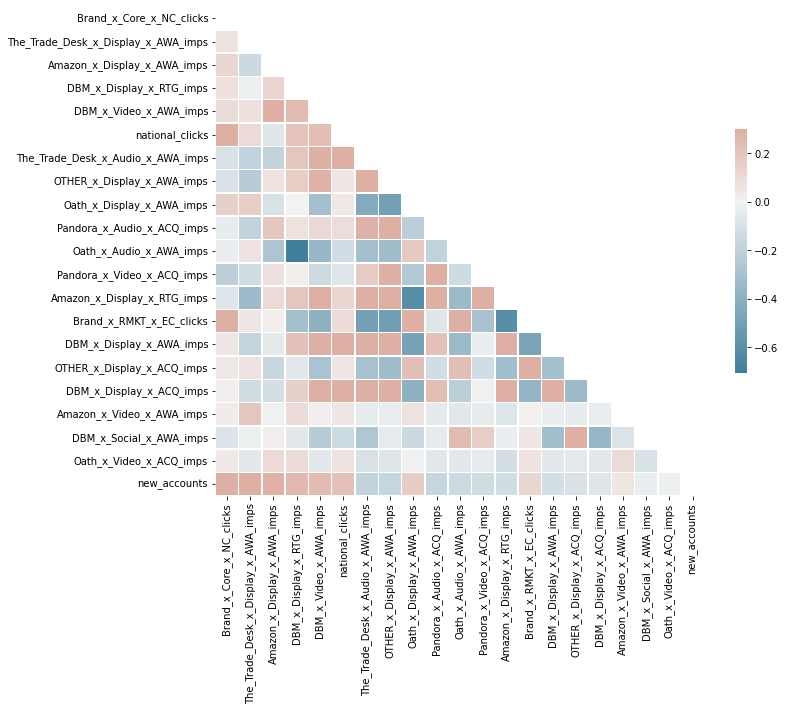

In [253]:
mask = np.triu(np.ones_like(correl, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correl, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [254]:
#@title Input 2nd correlation threshold (must be between -1 and 0)
THRESHOLD_2 =  -.6 #@param {type: "number"}

In [255]:
# feature reduction 1B: output correlations < threshold_2 to review for data reduction 
corrs_neg = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_neg = corrs_neg[corrs_neg < THRESHOLD_2].stack().reset_index() # user defines threshold and can decrease to be more conservative
corrs_neg = corrs_neg.loc[corrs_neg[0]<1.0]
corrs_neg

,level_0,level_1,0
0,DBM_x_Display_x_RTG_imps,Oath_x_Audio_x_AWA_imps,-0.70917
1,Oath_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,-0.61677
2,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,-0.60301


## Step 2: Check for Multicollinearity


Run variance inflation factor (VIF) analysis & review values > 7 

Notes: 
*   Industry best practice flags values > 10 as a violation of regression model assumptions

In [256]:
featureset_df.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts,day
0,17067,0.00000,334023.00000,1735596.00000,1826161.00000,2098,209733.00000,2653645.00000,0.00000,26265.00000,0.00000,0.00000,3198766.00000,5585,8400476.00000,0.00000,18284479.00000,39736.00000,0.00000,0.00000,1653,2019-03-25 00:00:00+00:00
1,13398,0.00000,801902.00000,1270805.00000,272857.00000,1351,158747.00000,7165284.00000,0.00000,45691.00000,0.00000,44125.00000,2144522.00000,3807,2464305.00000,10013.00000,4041579.00000,21794.00000,14818.00000,0.00000,1466,2018-11-29 00:00:00+00:00
2,9109,0.00000,631746.00000,1373478.00000,126028.00000,1120,103955.00000,6705270.00000,0.00000,18706.00000,0.00000,18161.00000,2357421.00000,2744,1292850.00000,4091.00000,4331451.00000,3959.00000,18102.00000,0.00000,604,2018-11-22 00:00:00+00:00
3,10787,0.00000,1522130.00000,1639503.00000,287042.00000,1157,166883.00000,9191794.00000,0.00000,25406.00000,0.00000,24560.00000,2792468.00000,3111,2702506.00000,2823.00000,3944924.00000,10078.00000,17707.00000,0.00000,891,2018-12-09 00:00:00+00:00
4,12781,0.00000,341272.00000,1369087.00000,1552542.00000,1665,197307.00000,477541.00000,0.00000,25011.00000,0.00000,0.00000,663885.00000,4211,5689437.00000,0.00000,13782058.00000,26261.00000,0.00000,0.00000,1023,2019-03-30 00:00:00+00:00


In [257]:
vif = add_constant(featureset_df.drop(columns=[DATE_COL, KPI_COL]))

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 
print(vif.sort_values(ascending=False))

const                                 71.79755
DBM_x_Display_x_AWA_imps              8.48802 
Amazon_x_Display_x_RTG_imps           6.32987 
DBM_x_Display_x_ACQ_imps              6.21413 
Brand_x_RMKT_x_EC_clicks              5.50143 
The_Trade_Desk_x_Audio_x_AWA_imps     4.34644 
Pandora_x_Video_x_ACQ_imps            3.56612 
Oath_x_Audio_x_AWA_imps               3.42597 
OTHER_x_Display_x_AWA_imps            3.18817 
DBM_x_Video_x_AWA_imps                3.16053 
DBM_x_Social_x_AWA_imps               2.95574 
Pandora_x_Audio_x_ACQ_imps            2.89014 
OTHER_x_Display_x_ACQ_imps            2.71269 
DBM_x_Display_x_RTG_imps              2.38016 
Oath_x_Display_x_AWA_imps             2.25538 
Brand_x_Core_x_NC_clicks              2.04897 
Amazon_x_Display_x_AWA_imps           1.94695 
national_clicks                       1.83830 
The_Trade_Desk_x_Display_x_AWA_imps   1.53189 
Oath_x_Video_x_ACQ_imps               1.13772 
Amazon_x_Video_x_AWA_imps             1.07458 
dtype: float6

In [258]:
# processing to output VIF results as a dataframe 
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [259]:
vif_df

,feature,vif
0,const,71.79755
15,DBM_x_Display_x_AWA_imps,8.48802
13,Amazon_x_Display_x_RTG_imps,6.32987
17,DBM_x_Display_x_ACQ_imps,6.21413
14,Brand_x_RMKT_x_EC_clicks,5.50143
7,The_Trade_Desk_x_Audio_x_AWA_imps,4.34644
12,Pandora_x_Video_x_ACQ_imps,3.56612
11,Oath_x_Audio_x_AWA_imps,3.42597
8,OTHER_x_Display_x_AWA_imps,3.18817
5,DBM_x_Video_x_AWA_imps,3.16053


In [260]:
vif_df = vif_df[vif_df['vif'] <= 5]
vif_df

,feature,vif
7,The_Trade_Desk_x_Audio_x_AWA_imps,4.34644
12,Pandora_x_Video_x_ACQ_imps,3.56612
11,Oath_x_Audio_x_AWA_imps,3.42597
8,OTHER_x_Display_x_AWA_imps,3.18817
5,DBM_x_Video_x_AWA_imps,3.16053
19,DBM_x_Social_x_AWA_imps,2.95574
10,Pandora_x_Audio_x_ACQ_imps,2.89014
16,OTHER_x_Display_x_ACQ_imps,2.71269
4,DBM_x_Display_x_RTG_imps,2.38016
9,Oath_x_Display_x_AWA_imps,2.25538


## Step 3: Feature Transformation

Options:
* SQRT 
* Log
* De-Mean
* In previous tests, application of SQRT function outperformed log


In [261]:
#@title Input transformation type (ex: log, sqrt)
transformation = 'None' #@param ["Square Root", "Mean","Log","Natural Log","None"]

In [262]:
X = featureset_df.drop(columns=[DATE_COL,KPI_COL])

# These transformations stabilize large values in the dataset, and allow the data to be more normal
if transformation == "Square Root":
  X_transform = X.apply(np.sqrt)
elif transformation == "Mean":
  X_transform = X/X.mean()
elif transformation == "Natural Log": 
  X += 1 # natural log function is not defined at 0 so need to add 1 to each value 
  X_transform = X.apply(np.log)
else:
  X_transform = X

In [263]:
X_transform.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps
0,17067,0.00000,334023.00000,1735596.00000,1826161.00000,2098,209733.00000,2653645.00000,0.00000,26265.00000,0.00000,0.00000,3198766.00000,5585,8400476.00000,0.00000,18284479.00000,39736.00000,0.00000,0.00000
1,13398,0.00000,801902.00000,1270805.00000,272857.00000,1351,158747.00000,7165284.00000,0.00000,45691.00000,0.00000,44125.00000,2144522.00000,3807,2464305.00000,10013.00000,4041579.00000,21794.00000,14818.00000,0.00000
2,9109,0.00000,631746.00000,1373478.00000,126028.00000,1120,103955.00000,6705270.00000,0.00000,18706.00000,0.00000,18161.00000,2357421.00000,2744,1292850.00000,4091.00000,4331451.00000,3959.00000,18102.00000,0.00000
3,10787,0.00000,1522130.00000,1639503.00000,287042.00000,1157,166883.00000,9191794.00000,0.00000,25406.00000,0.00000,24560.00000,2792468.00000,3111,2702506.00000,2823.00000,3944924.00000,10078.00000,17707.00000,0.00000
4,12781,0.00000,341272.00000,1369087.00000,1552542.00000,1665,197307.00000,477541.00000,0.00000,25011.00000,0.00000,0.00000,663885.00000,4211,5689437.00000,0.00000,13782058.00000,26261.00000,0.00000,0.00000


In [264]:
X_transform.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,14329.43657,22417.86985,419435.70181,1467573.37562,375140.97035,1322.95222,90002.67875,2937961.65898,65537.88962,7640.60297,14649.29819,3870.50577,853109.05601,6327.87644,1938494.68863,58332.66227,3860111.70181,51340.90774,11141.41351,2760.56837
std,2300.49043,54948.20265,633522.18596,481990.16535,436246.71971,301.83336,119544.59266,2793634.29831,88365.99537,15912.44494,35598.40499,11522.20125,1027558.55465,2882.91855,2138513.71255,148542.43734,3824957.66960,330060.80218,15708.80786,20168.82398
min,7894.00000,0.00000,0.00000,135172.00000,0.00000,535.00000,0.00000,139.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2327.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,12746.00000,0.00000,6.00000,1323660.50000,3.00000,1135.00000,0.00000,647711.50000,0.00000,0.00000,0.00000,0.00000,0.00000,4073.00000,313889.00000,0.00000,2027536.50000,23.50000,0.00000,0.00000
50%,14275.00000,0.00000,98193.00000,1557938.00000,240777.00000,1293.00000,42017.00000,1611886.00000,1.00000,0.00000,0.00000,0.00000,0.00000,5298.00000,1202255.00000,0.00000,2783977.00000,13987.00000,0.00000,0.00000
75%,15913.00000,0.00000,682694.50000,1750653.50000,646051.00000,1486.00000,154324.00000,5092391.50000,117787.00000,0.00000,0.00000,0.00000,1666294.50000,8145.00000,2465588.50000,3129.00000,4409461.50000,40502.50000,20685.50000,0.00000
max,21552.00000,319197.00000,2859646.00000,2433525.00000,2889383.00000,3206.00000,786651.00000,10345069.00000,395993.00000,148195.00000,129781.00000,144791.00000,4003753.00000,16450.00000,8800172.00000,1076835.00000,20506222.00000,7896180.00000,66344.00000,208873.00000


### Standardize Features

Puts data on the same scale and optimizes performance and interpretability

In [265]:
standardize_features = "Yes" #@param {type: "string"}


In [266]:
if standardize_features == "No":
  X_transform_stand = X_transform
elif standardize_features == "Yes":
  #scaler = StandardScaler()
  scaler = MinMaxScaler()
  #standardized_transform = scaler.fit_transform(X_transform)
  standardized_transform = MinMaxScaler().fit_transform(X_transform)
  X_transform_stand = pd.DataFrame(standardized_transform, columns = X.columns)
else:
  X_transform_stand = X_transform

In [267]:
X_transform_stand.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'DBM_x_Video_x_AWA_imps', 'national_clicks',
       'The_Trade_Desk_x_Audio_x_AWA_imps', 'OTHER_x_Display_x_AWA_imps',
       'Oath_x_Display_x_AWA_imps', 'Pandora_x_Audio_x_ACQ_imps',
       'Oath_x_Audio_x_AWA_imps', 'Pandora_x_Video_x_ACQ_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
       'DBM_x_Display_x_ACQ_imps', 'Amazon_x_Video_x_AWA_imps',
       'DBM_x_Social_x_AWA_imps', 'Oath_x_Video_x_ACQ_imps'],
      dtype='object')

###Run regression results to review p-values for data reduction only

In [268]:
# add column of 1's to estimate intercept parameter
X_transform_stand = sm.add_constant(X_transform_stand) 

# define Y
Y = featureset_df[[KPI_COL]]

# run OLS model using statsmodels package for p-values
model = sm.OLS(Y, X_transform_stand)
results = model.fit()
predictions = model.predict(results.params) 

print_model = results.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           new_accounts   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     112.5
Date:                Mon, 20 Sep 2021   Prob (F-statistic):          1.39e-185
Time:                        14:30:06   Log-Likelihood:                -4103.3
No. Observations:                 607   AIC:                             8249.
Df Residuals:                     586   BIC:                             8341.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 371.2814     52.162      7.118      0.000     268.835     473.728
Brand_x_Core_x_NC_clicks             2263.9731     73.337     30.871      0.000    2119.937    2408.009
The_Trade_Desk_x_Display_x_AWA_imps   438.3825     62.045      7.066      0.000     316.524     560.241
Amazon_x_Display_x_AWA_imps           420.0611     54.352      7.728      0.000     313.312     526.810
DBM_x_Display_x_RTG_imps              508.3051     63.485      8.007      0.000     383.619     632.992
DBM_x_Video_x_AWA_imps                701.9218    101.612      6.908      0.000     502.354     901.489
national_clicks                      -204.4419    103.540     -1.975      0.049    -407.796      -1.088
The_Trade_Desk_x_Audio_x_AWA_imps     106.9328    118.389      0.903      0.367    -125.585     339.451
OTHER_x_Display_x_AWA_imps           -198.9543     57.058     -3.487      0.001    -311.018     -86.890
Oath_x_Display_x_AWA_imps             192.1651     58.077      3.309      0.001      78.101     306.229
Pandora_x_Audio_x_ACQ_imps           -622.3326    136.630     -4.555      0.000    -890.677    -353.988
Oath_x_Audio_x_AWA_imps               282.8158     58.232      4.857      0.000     168.447     397.185
Pandora_x_Video_x_ACQ_imps            992.9078    204.784      4.849      0.000     590.708    1395.107
Amazon_x_Display_x_RTG_imps          -226.1859     84.596     -2.674      0.008    -392.334     -60.038
Brand_x_RMKT_x_EC_clicks             -873.4547     99.157     -8.809      0.000   -1068.201    -678.708
DBM_x_Display_x_AWA_imps             -834.5862    103.460     -8.067      0.000   -1037.784    -631.388
OTHER_x_Display_x_ACQ_imps           -269.9625    103.036     -2.620      0.009    -472.328     -67.597
DBM_x_Display_x_ACQ_imps              611.1214    115.330      5.299      0.000     384.612     837.631
Amazon_x_Video_x_AWA_imps            -230.6828    214.010     -1.078      0.282    -651.002     189.636
DBM_x_Social_x_AWA_imps                89.6293     62.659      1.430      0.153     -33.434     212.693
Oath_x_Video_x_ACQ_imps              -270.2923     95.326     -2.835      0.005    -457.514     -83.070
==============================================================================
Omnibus:                       24.352   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.360
Skew:                          -0.325   Prob(JB):                     7.72e-09
Kurtosis:                       4.027   Cond. No.                         39.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Implement FINAL feature selection logic based on analysis of above results

Set your p-Value threshold. This removes features with P values greater than the threshold below. For example: 
*   p-Value <= .1 / 90% significance 

In [269]:
#@title Input p-Value threshold
P_THRESHOLD =  .1 #@param {type: "number"}

In [270]:
# FINAL feature selection/data reduction
results_df = (results.summary2().tables[1])
sig_input = list(results_df[results_df['P>|t|']<=P_THRESHOLD].index)[1:]
X_inputs = X_transform_stand[sig_input] 
X_inputs = X_transform_stand
X_inputs.columns

Index(['const', 'Brand_x_Core_x_NC_clicks',
       'The_Trade_Desk_x_Display_x_AWA_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'DBM_x_Video_x_AWA_imps', 'national_clicks',
       'The_Trade_Desk_x_Audio_x_AWA_imps', 'OTHER_x_Display_x_AWA_imps',
       'Oath_x_Display_x_AWA_imps', 'Pandora_x_Audio_x_ACQ_imps',
       'Oath_x_Audio_x_AWA_imps', 'Pandora_x_Video_x_ACQ_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
       'DBM_x_Display_x_ACQ_imps', 'Amazon_x_Video_x_AWA_imps',
       'DBM_x_Social_x_AWA_imps', 'Oath_x_Video_x_ACQ_imps'],
      dtype='object')

## Steps 4 & 5 Reduce Feature Set (Optional)

Feature selection methods if > 50 inputs remain after 3-step data reduction process

In [271]:
X_inputs.describe()

,const,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,1.00000,0.47118,0.07023,0.14667,0.57972,0.12983,0.29500,0.11441,0.28399,0.16550,0.05156,0.11288,0.02673,0.21308,0.28329,0.22028,0.05417,0.18824,0.00650,0.16793,0.01322
std,0.00000,0.16844,0.17215,0.22154,0.20971,0.15098,0.11300,0.15197,0.27005,0.22315,0.10738,0.27430,0.07958,0.25665,0.20413,0.24301,0.13794,0.18653,0.04180,0.23678,0.09656
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,0.35525,0.00000,0.00000,0.51710,0.00000,0.22463,0.00000,0.06260,0.00000,0.00000,0.00000,0.00000,0.00000,0.12363,0.03567,0.00000,0.09887,0.00000,0.00000,0.00000
50%,1.00000,0.46720,0.00000,0.03434,0.61904,0.08333,0.28379,0.05341,0.15580,0.00000,0.00000,0.00000,0.00000,0.00000,0.21037,0.13662,0.00000,0.13576,0.00177,0.00000,0.00000
75%,1.00000,0.58713,0.00000,0.23873,0.70289,0.22359,0.35605,0.19618,0.49225,0.29745,0.00000,0.00000,0.00000,0.41618,0.41195,0.28018,0.00291,0.21503,0.00513,0.31179,0.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [272]:
len(X_inputs.columns)

21

###Step 4: KBest

Top features based on univariate testing


In [273]:
k_best = SelectKBest(f_regression, k=len(X_inputs.columns))
k_best.fit_transform(X_inputs, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


array([[1.00000000e+00, 6.71621028e-01, 0.00000000e+00, ...,
        5.03230676e-03, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.02987260e-01, 0.00000000e+00, ...,
        2.76006879e-03, 2.23351019e-01, 0.00000000e+00],
       [1.00000000e+00, 8.89588520e-02, 0.00000000e+00, ...,
        5.01381681e-04, 2.72850597e-01, 0.00000000e+00],
       ...,
       [1.00000000e+00, 5.07687802e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 6.12241910e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.83467565e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

###Step 5: Recursive Feature Elimination (RFE)

Rank features based on recursive model testing

In [274]:
lm = LinearRegression()
rfe = RFE(lm, 1)
X_rfe = rfe.fit_transform(X_inputs,Y)
lm.fit(X_rfe,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Output results of optional feature selection process

In [275]:
# create dataframe with KBest and RFE results
opt_datared_df = pd.DataFrame({'feature': X_inputs.columns, 'p_value': k_best.pvalues_, 'rfe_rank': rfe.ranking_}).sort_values('p_value')
opt_datared_df

,feature,p_value,rfe_rank
1,Brand_x_Core_x_NC_clicks,0.00000,1
2,The_Trade_Desk_x_Display_x_AWA_imps,0.00000,8
3,Amazon_x_Display_x_AWA_imps,0.00000,9
4,DBM_x_Display_x_RTG_imps,0.00000,12
5,DBM_x_Video_x_AWA_imps,0.00000,2
6,national_clicks,0.00000,17
7,The_Trade_Desk_x_Audio_x_AWA_imps,0.00000,19
8,OTHER_x_Display_x_AWA_imps,0.00002,16
9,Oath_x_Display_x_AWA_imps,0.00003,18
10,Pandora_x_Audio_x_ACQ_imps,0.00003,6


#### Implement OPTIONAL feature selection logic based on analysis of above results
Set your p-Value threshold. For example: 
*   p-Value <= .1 / 90% significance OR
*   top 75%+ of ranking (e.g. top 15 of total 20)


In [276]:
#@title Input p-Value and rank thresholds
P_THRESHOLD_OPT =  .1 #@param {type: "number"}
RANK_THRESHOLD =  1 #@param {type: "number"}

In [277]:
# OPTIONAL feature selection/data reduction

opt_reduction = opt_datared_df[((opt_datared_df['p_value']<=P_THRESHOLD_OPT) | 
                             (opt_datared_df['rfe_rank'] <= RANK_THRESHOLD))] 

In [278]:
# create list of FINAL model inputs, overwriting previous input feature list.
opt_inputs =[]   

for index, rows in opt_reduction.iterrows(): # iterate over each row 
    opt_inputs.append(rows.feature) 

X_inputs = X_inputs[opt_inputs]

# Compile Final Dataset

In [279]:
data = X_inputs
data[KPI_COL] = Y
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,new_accounts
0,0.67162,0.00000,0.11681,0.69634,0.63202,0.58517,0.26662,0.25650,0.00000,0.17723,0.00000,0.00000,0.79894,0.23069,0.95458,0.00000,0.89166,1653
1,0.40299,0.00000,0.28042,0.49411,0.09443,0.30550,0.20180,0.69262,0.00000,0.30832,0.00000,0.30475,0.53563,0.10479,0.28003,0.00930,0.19709,1466
2,0.08896,0.00000,0.22092,0.53878,0.04362,0.21902,0.13215,0.64816,0.00000,0.12623,0.00000,0.12543,0.58880,0.02953,0.14691,0.00380,0.21123,604
3,0.21182,0.00000,0.53228,0.65453,0.09934,0.23287,0.21214,0.88852,0.00000,0.17144,0.00000,0.16962,0.69746,0.05551,0.30710,0.00262,0.19238,891
4,0.35781,0.00000,0.11934,0.53687,0.53733,0.42306,0.25082,0.04615,0.00000,0.16877,0.00000,0.00000,0.16582,0.13340,0.64651,0.00000,0.67209,1023


# Visualize Target Variable and Features

In [280]:
len(data.columns)

18

In [281]:
data.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'DBM_x_Video_x_AWA_imps', 'national_clicks',
       'The_Trade_Desk_x_Audio_x_AWA_imps', 'OTHER_x_Display_x_AWA_imps',
       'Oath_x_Display_x_AWA_imps', 'Pandora_x_Audio_x_ACQ_imps',
       'Oath_x_Audio_x_AWA_imps', 'Pandora_x_Video_x_ACQ_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
       'DBM_x_Display_x_ACQ_imps', 'new_accounts'],
      dtype='object')

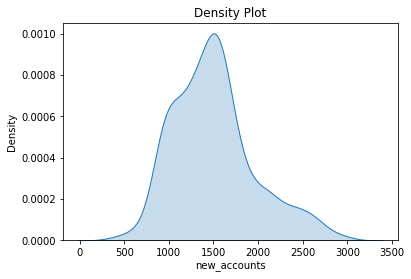

In [282]:
sns.kdeplot(data[KPI_COL], label = KPI_COL, shade = True)
plt.xlabel(KPI_COL); plt.ylabel('Density'); plt.title('Density Plot');

Plot some features

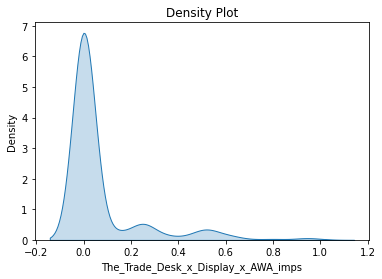

In [283]:
sns.kdeplot(data[data.columns[1]], label = '', shade = True)
plt.xlabel(data.columns[1]); plt.ylabel('Density'); plt.title('Density Plot');

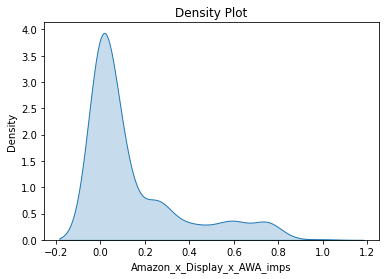

In [284]:
sns.kdeplot(data[data.columns[2]], label = '', shade = True)
plt.xlabel(data.columns[2]); plt.ylabel('Density'); plt.title('Density Plot');

Look at relationship of individual features with target data

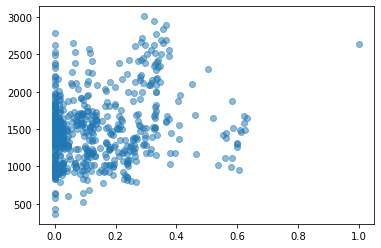

In [285]:
plt.plot(data[data.columns[4]], data['new_accounts'],'o',alpha=0.5)
plt.show()

In [286]:
#@title Name data export sheet

# Naming for final data export
SHEET_NAME = 'model input data 9.20.21' #@param {type:"string"}
TAB_NAME = 'results' #@param {type:"string"}

In [287]:
# create new spreadsheet
gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.create(SHEET_NAME)

# generate link for file 
SHEET_URL = "https://docs.google.com/spreadsheets/d/"+sh.id
print("Sheet URL is " + SHEET_URL)

Sheet URL is https://docs.google.com/spreadsheets/d/1HBy28CZkpSK0Ch83F8rGv_gFhz7qqOa-fkrniRAv5Uc


In [288]:
worksheet = sh.add_worksheet(title= TAB_NAME, rows=len(data), cols=len(data.columns))
set_with_dataframe(worksheet, data)